In [1]:
from noise_control import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
rc_data = np.load("boptest_data.npz")
A = rc_data["A"]
B = rc_data["B"]
D = rc_data["D"]
R = rc_data["R"]
COP = rc_data["COP"]

In [3]:
sim_day = 7
Tsim = int(sim_day*24*4)
# noise_basic = np.array([45, 47, 52, 55, 57, 59, 60, 62, 66, 63, 
#                        62, 64, 63, 64, 63, 62, 61, 61, 67, 60, 58, 59, 56, 52, 49])
noise_basic = np.array([43, 42, 41.5, 42, 43, 42, 45, 52, 57,  
                       58, 64, 63, 64, 63, 62, 61, 61, 65, 60, 55, 48, 47, 44, 42])
nos_24_normal = np.repeat(noise_basic, 4)

nos_24_noisy = nos_24_normal + (nos_24_normal >= 60)*nos_24_normal*0.1 

nos_24_quite = nos_24_normal - (nos_24_normal >= 60)*nos_24_normal*0.05

noise_base = {"quite": nos_24_quite, "normal": nos_24_normal, "noisy": nos_24_noisy}

noise_pattern = "normal"

amb_nos_list = np.tile(noise_base[noise_pattern], sim_day+1)

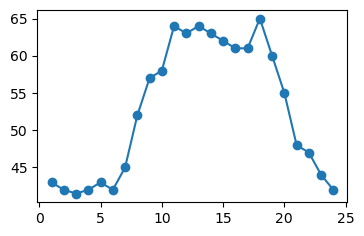

In [5]:
len(noise_basic)
plt.figure(figsize = (4,2.5))
plt.plot(list(range(1,25)), noise_basic)
plt.scatter(list(range(1,25)), noise_basic)

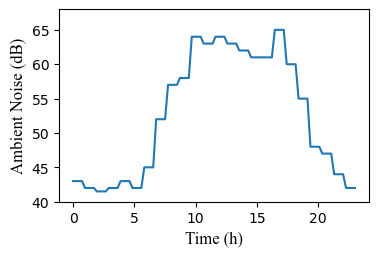

In [54]:
cs_font = {"fontname":"Times New Roman"}
font_size = {"fontsize": 12}

plt.figure(figsize=(4,2.5))
x_label = np.linspace(0,23,len(noise_base[noise_pattern]) )
plt.plot(x_label, noise_base[noise_pattern])
plt.ylim([40,68])

plt.xlabel("Time (h)", **cs_font, **font_size)
plt.ylabel("Ambient Noise (dB)", **cs_font, **font_size)
plt.savefig("amb_noise.pdf", bbox_inches = "tight")

In [6]:
eta_list_res = np.logspace(-6, -1, 12)

energy_cost_list_res = []
noise_cost_list_res = []
noise_list_res = []
temp_list_res = []
obj_opt_res = "ambient_res"
ele_price_pat_res = "highly_dynamic"
N = 4*8 ### prediction horizon is 12 hours
noise_cost_list_res = []
f_nos_list_res = []
build_type_res = "normal"
###### open-loop simulation #######
for eta in tqdm(eta_list_res):
    hp_mpc_res = NoiseCtr(A,B,D,R, N = N, platform = "local", obj_opt = obj_opt_res, ele_price_pat = ele_price_pat_res,
                          build_type = build_type_res)
    obj_opt_res = hp_mpc_res.obj_opt
    ele_price_pat_res = hp_mpc_res.ele_price_pat
    build_type_res = hp_mpc_res.build_type
    hp_mpc_res.init_state()
    hp_mpc_res.initialize_buff()
    hp_mpc_res.delta = 0
    for t in range(Tsim):
        hp_mpc_res.open_loop = False
        amb_nos = amb_nos_list[t:t+N]
      
        hp_mpc_res.get_forecast()
        hp_mpc_res.mpc_ctr(amb_nos, eta)
        hp_mpc_res.step()
        
    energy_cost_list_res.append(hp_mpc_res.energy_cost)
    
    noise_cost_list_res.append(hp_mpc_res.noise_cost)
    noise_list_res.append(hp_mpc_res.mixed_noise_list)
    temp_list_res.append(hp_mpc_res.ti_list) 
    f_nos_list_res.append(hp_mpc_res.f_nos_list)
    
#np.savez(f"{obj_opt}_{ele_price_pat}_{build_type}_{sim_day}.npz", noise_cost = noise_cost_list, energy_cost = energy_cost_list)

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:03:42<00:00, 618.57s/it]


In [52]:
np.savez(f"{obj_opt_res}_{ele_price_pat_res}_{build_type_res}_{sim_day}.npz", 
         noise_cost = noise_cost_list_res, energy_cost = energy_cost_list_res, ti_list_res = temp_list_res, 
f_nos_list = f_nos_list_res, noise_list = noise_list_res)


## Plot Simulation Results 

reduction of Lden is:  2.599163284424897
Lden reduction percentage is:  0.695203821253834
L quite reduction is:  6.147639159866237
domination time reduction is:  3.3928571428571423


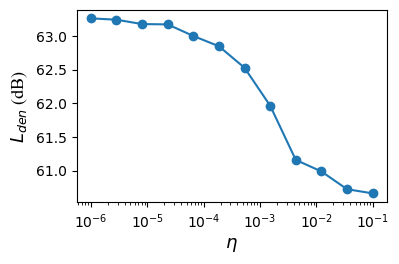

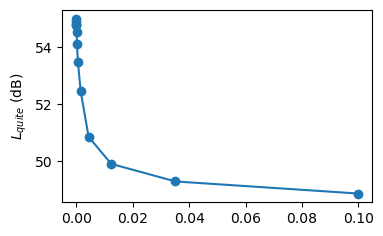

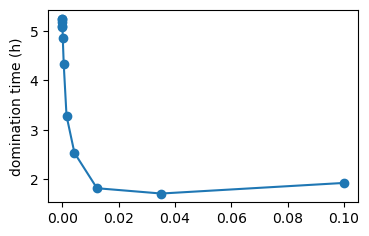

In [20]:
#### compute the Lden value for the simulated data ######
day_penalty = 0
evening_penalty = 5
night_penalty = 10
penalty = np.concatenate((10*np.ones(7), np.zeros(12), 5*np.ones(4), 10*np.ones(1)))
penalty_list = penalty

quite_filter = np.ones(24)
quite_filter[8:22] = 0
L_quite_list_res = []
domination_list = []

Lden_list_res = []


cs_font = {"fontname":"Times New Roman"}
font_size = {"fontsize": 13}

########################## compute ambient Lden ###################
Lden_list_amb = []
for iter in range(len(eta_list_res)):
    L_den = 0
    for day in range(sim_day): 
        L_orig = amb_nos_list[day*24*4:(day+1)*24*4]
        assert len(L_orig) == 24*4

        
        L_per_day = np.array([ 10*np.log10( 1/4*sum( 10**( np.array(L_orig[t:t+4])/10 ) ) ) for t in range(0, 24*4,4) ])

        L_per_day += penalty_list
        assert len(L_per_day) == 24
        
        L_nit = 10*np.log10( 1/8*(sum(10**(np.array(L_per_day[t]/10)) for t in range(7) ) + 10**(L_per_day[-1]/10) ) )
        L_eve = 10*np.log10( 1/4*(sum(10**(np.array(L_per_day[t]/10)) for t in range(19,23)) ) )
        L_day = 10*np.log10( 1/12*(sum(10**(np.array(L_per_day[t]/10)) for t in range(7,19)) ) )

        L_den += 10*np.log10(1/24*(12*(10**(L_day/10)) + 4*(10**(L_eve/10)) + 8*(10**(L_nit/10)) ))

    
    Lden_list_amb.append(L_den/sim_day)
#######################################################################

# plt.figure(figsize = (4,2.5))
# plt.plot(eta_list_res, Lden_list_amb)
# plt.scatter(eta_list_res, Lden_list_amb)
# plt.xscale("log")
# plt.xlabel("$\eta$", **cs_font, **font_size)
# plt.ylabel("$L_{den}$ (dB)", **cs_font, **font_size)



for iter in range(len(eta_list_res)):
    L_den = 0
    L_quite = 0
    domi_time = 0
    for day in range(sim_day): 
        L_orig = noise_list_res[iter][day*24*4:(day+1)*24*4]
        assert len(L_orig) == 24*4

        L_per_day = np.array([ 10*np.log10( 1/4*sum(10**( np.array(L_orig[t:t+4])/10 )) ) for t in range(0, 24*4,4) ])

        L_quite_day = L_per_day*quite_filter
        L_quite_day = np.array(L_quite_day[L_quite_day >0])

        L_per_day += penalty_list
      
        L_nit = 10*np.log10( 1/8*(sum(10**(np.array(L_per_day[t]/10)) for t in range(7) ) + 10**(L_per_day[-1]/10) ) )
        L_eve = 10*np.log10( 1/4*(sum(10**(np.array(L_per_day[t]/10)) for t in range(19,23)) ) )
        L_day = 10*np.log10( 1/12*(sum(10**(np.array(L_per_day[t]/10)) for t in range(7,19)) ) )

        L_den += 10*np.log10(1/24*(12*(10**(L_day/10)) + 4*(10**(L_eve/10)) + 8*(10**(L_nit/10)) ))

        L_quite += 10*np.log10( 1/(len(L_quite_day)) *sum(10**(L_quite_day/10) ) )
 
        domi_time += sum( (f_nos_list_res[iter][day*24*4:(day+1)*24*4] - nos_24_normal ) > 0)/4
    
    Lden_list_res.append(L_den/sim_day)
    L_quite_list_res.append(L_quite/sim_day)
    domination_list.append(domi_time/sim_day)

###########  Plot Pareto Curves ###########
plt.figure(figsize = (4,2.5))
plt.plot(eta_list_res, Lden_list_res)
plt.scatter(eta_list_res, Lden_list_res)
plt.xscale("log")
plt.xlabel("$\eta$", **cs_font, **font_size)
plt.ylabel("$L_{den}$ (dB)", **cs_font, **font_size)
plt.savefig(f"{hp_mpc_res.open_loop}_{sim_day}_{noise_pattern}_{hp_mpc_res.obj_opt}_lden.pdf", bbox_inches = "tight")
#plt.title(f"{hp_mpc.ele_price_pat}_{hp_mpc.build_type}")


print("reduction of Lden is: ", Lden_list_res[0] - np.min(Lden_list_res))
print("Lden reduction percentage is: ", (Lden_list_res[0] - np.min(Lden_list_res))/(Lden_list_res[0] - Lden_list_amb[0]) )



plt.figure(figsize = (4,2.5))
plt.plot(eta_list_res, L_quite_list_res)
plt.scatter(eta_list_res, L_quite_list_res)
plt.ylabel("$L_{quite}$ (dB)")

print("L quite reduction is: ", L_quite_list_res[0] - np.min(L_quite_list_res))

plt.figure(figsize = (4,2.5))
plt.plot(eta_list_res, domination_list)
plt.scatter(eta_list_res, domination_list)
plt.ylabel("domination time (h)")

print("domination time reduction is: ", domination_list[0] - np.min(domination_list))

In [50]:
print("noise cost reduction is: ", (np.max(noise_cost_list_res) - np.min(noise_cost_list_res))/np.max(noise_cost_list_res) )
print("energy cost increase is: ", (energy_cost_list_res[np.argmin(noise_cost_list_res)] - energy_cost_list_res[np.argmax(noise_cost_list_res)])
      /energy_cost_list_res[np.argmax(noise_cost_list_res)] )

noise cost reduction is:  0.847461760428238
energy cost increase is:  0.03568209335490135


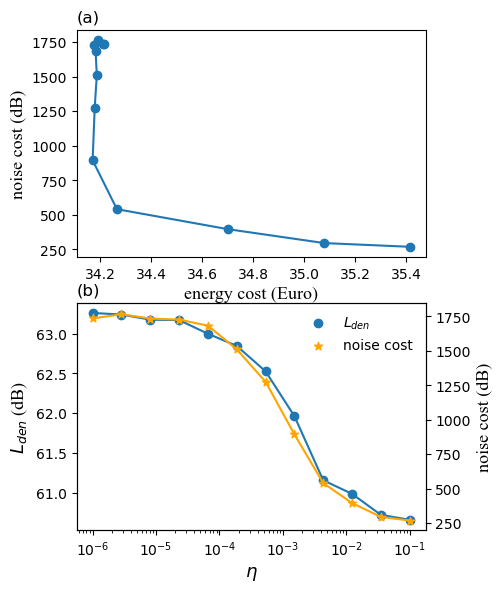

In [17]:

cs_font = {"fontname":"Times New Roman"}
font_size = {"fontsize": 13}

fig, ax = plt.subplots(2,1,figsize = (4.5,6.5))
#plt.subplot(211)
ax[0].plot(np.array(energy_cost_list_res), np.array(noise_cost_list_res))
ax[0].scatter(np.array(energy_cost_list_res), np.array(noise_cost_list_res))
ax[0].set_xlabel("energy cost (Euro)", **cs_font, **font_size)
ax[0].set_ylabel("noise cost (dB)", **cs_font, **font_size)
ax[0].set_title("(a)", loc = "left")

ax[1].plot(eta_list_res, Lden_list_res)
scatter1 = ax[1].scatter(eta_list_res, Lden_list_res)
ax[1].set_xscale("log")
ax[1].set_xlabel("$\eta$", **cs_font, **font_size)
ax[1].set_ylabel("$L_{den}$ (dB)", **cs_font, **font_size)
ax[1].set_title("(b)", loc = "left")

ax_new = ax[1].twinx()
ax_new.set_ylim([200,1850])
ax_new.plot(eta_list_res, noise_cost_list_res, "orange")
scatter2 = ax_new.scatter(eta_list_res, noise_cost_list_res, c = "orange", marker = "*")

ax_new.set_ylabel("noise cost (dB)", **font_size, **cs_font)
ax_new.legend([scatter1, scatter2], ["$L_{den}$", "noise cost"], frameon = False)

plt.savefig(f"{hp_mpc_res.open_loop}_{sim_day}_{noise_pattern}_{hp_mpc_res.obj_opt}_both_new.pdf", bbox_inches = "tight")

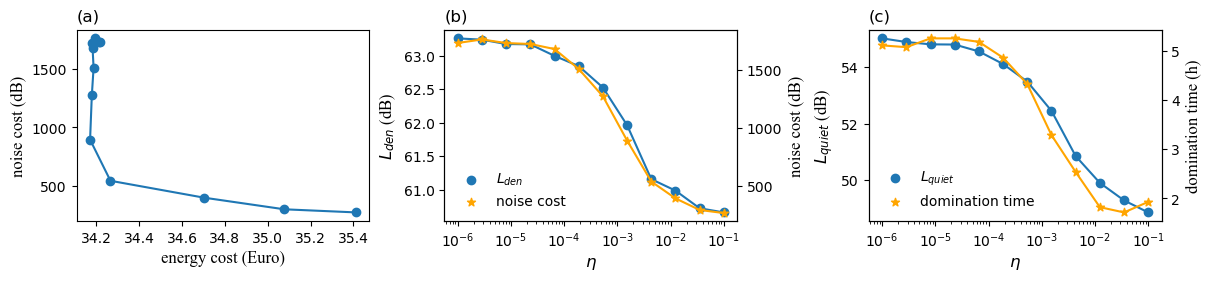

In [62]:
fig, ax = plt.subplots(1,3,figsize = (12,2.7), constrained_layout = True)
#plt.subplot(211)
ax[0].plot(np.array(energy_cost_list_res), np.array(noise_cost_list_res))
ax[0].scatter(np.array(energy_cost_list_res), np.array(noise_cost_list_res))
ax[0].set_xlabel("energy cost (Euro)", **cs_font, **font_size)
ax[0].set_ylabel("noise cost (dB)", **cs_font, **font_size)
ax[0].set_title("(a)", loc = "left")
#ax[0].set_ylim([0,1900])

ax[1].plot(eta_list_res, Lden_list_res)
scatter1 = ax[1].scatter(eta_list_res, Lden_list_res)
ax[1].set_xscale("log")
ax[1].set_xlabel("$\eta$", **cs_font, **font_size)
ax[1].set_ylabel("$L_{den}$ (dB)", **cs_font, **font_size)
ax[1].set_title("(b)", loc = "left")

ax_new = ax[1].twinx()
ax_new.set_ylim([200,1850])
ax_new.plot(eta_list_res, noise_cost_list_res, "orange")
scatter2 = ax_new.scatter(eta_list_res, noise_cost_list_res, c = "orange", marker = "*")

ax_new.set_ylabel("noise cost (dB)", **font_size, **cs_font)
ax_new.legend([scatter1, scatter2], ["$L_{den}$", "noise cost"], frameon = False, loc =3)
#ax_new.set_ylim([0,1900])

ax[2].plot(eta_list_res, L_quite_list_res)
sc1 = ax[2].scatter(eta_list_res, L_quite_list_res)
ax[2].set_ylabel("$L_{quiet}$ (dB)", **cs_font, **font_size)
ax[2].set_xscale("log")
ax[2].set_xlabel("$\eta$", **cs_font, **font_size)

ax_2 = ax[2].twinx()
ax_2.plot(eta_list_res, domination_list, color = "orange")
sc2 = ax_2.scatter(eta_list_res, domination_list, color = "orange", marker = "*")
ax_2.set_ylabel("domination time (h)", **cs_font, **font_size)

ax_2.legend([sc1,sc2], ["$L_{quiet}$", "domination time"], frameon = False, loc = 3)
ax_2.set_title("(c)", loc = "left")


plt.savefig(f"{hp_mpc_res.open_loop}_{sim_day}_{noise_pattern}_{hp_mpc_res.obj_opt}_all.pdf", bbox_inches = "tight")
#fig.tight_layout()